In [1]:
from __future__ import print_function
import ipywidgets as widgets
from transformers import pipeline
# from simpletransformers.t5 import T5Model, T5Args
import pandas as pd
import logging
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
import json
import random
# Pull reddit data from reddit api
import requests
from bs4 import BeautifulSoup
import math
#tf for RNN
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
df = pd.read_csv('similar_subreddits_1000_df.csv')
#df = pd.read_csv('handpicked_subreddits_1000_df.csv')
#df = pd.read_csv('random_subreddits_1000_df.csv')
df.head()

,subreddit,text
0,gaming,(ACIII SPOILER) I think he cut it a little too...
1,gaming,I tried recreating the hi-tech city from the B...
2,gaming,StorySave Pro v1.23.1 [Latest]
3,gaming,Damn these Nazi killing bad bitches look good.
4,gaming,Another one.


In [3]:
# Check if there is body text in reddit post
print(df['text'][0])

(ACIII SPOILER) I think he cut it a little too much


In [4]:
# Check if total is correct per subreddit
df['subreddit'].value_counts()

gaming             1000
PS4                1000
pokemon            1000
xboxone            1000
leagueoflegends    1000
Name: subreddit, dtype: int64

In [5]:
possible_labels = df.subreddit.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'gaming': 0, 'PS4': 1, 'pokemon': 2, 'xboxone': 3, 'leagueoflegends': 4}

In [6]:
#de-slang text
slang = pd.read_csv('slangit.csv')
slangit_dict = slang.set_index('Slang Term').to_dict()
slangit_dict = slangit_dict['Meaning']

def slang_lookup(text, dictionary):
    
    try:
        pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in dictionary.keys()) + r')(?!\w)')
        result = pattern.sub(lambda x: dictionary[x.group()], text)
    except:
        result = text

    return result

df['text'] = df['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df['text'].head()

0    (ACIII SPOILER) I think he cut it a little too...
1    I tried recreating the hi-tech city from the B...
2                       StorySave Pro v1.23.1 [Latest]
3       Damn these Nazi killing bad bitches look good.
4                                         Another one.
Name: text, dtype: object

In [7]:
df['label'] = df.subreddit.replace(label_dict)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [9]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [10]:
df.groupby(['subreddit', 'label', 'data_type']).count()

text
subreddit       label data_type      
PS4             1     train       800
                      val         200
gaming          0     train       800
                      val         200
leagueoflegends 4     train       800
                      val         200
pokemon         2     train       800
                      val         200
xboxone         3     train       800
                      val         200

In [11]:
df.head()

,subreddit,text,label,data_type
0,gaming,(ACIII SPOILER) I think he cut it a little too...,0,train
1,gaming,I tried recreating the hi-tech city from the B...,0,val
2,gaming,StorySave Pro v1.23.1 [Latest],0,train
3,gaming,Damn these Nazi killing bad bitches look good.,0,train
4,gaming,Another one.,0,val


In [12]:
train_dataset = df[df.data_type == 'train']
val_dataset = df[df.data_type == 'val']

train_dataset = train_dataset.drop(['subreddit','data_type'], axis = 1)
val_dataset = val_dataset.drop(['subreddit','data_type'], axis = 1)
train_X, train_Y = train_dataset['text'], train_dataset['label']
test_X, test_Y = val_dataset['text'], val_dataset['label']
hot_train_Y = pd.get_dummies(train_dataset.label)
hot_test_Y = pd.get_dummies(val_dataset.label)
hot_test_Y


,0,1,2,3,4
1,1,0,0,0,0
4,1,0,0,0,0
13,1,0,0,0,0
14,1,0,0,0,0
20,1,0,0,0,0
...,...,...,...,...,...
4979,0,0,0,0,1
4982,0,0,0,0,1
4986,0,0,0,0,1
4987,0,0,0,0,1


In [13]:
test_X

1       I tried recreating the hi-tech city from the B...
4                                            Another one.
13      Disney Japan is making a simulator to date "ha...
14                               ESO Chads vs ESO Casuals
20      Tiefling miniature for D&amp;D made from polym...
                              ...                        
4979    You almost always see that same champions. And...
4982     \n\nHey, I've been having this argument with ...
4986                 Meme of Legends Twitch Tales Edition
4987    Did Riot remove the feature where you are info...
4999    If not, anyone have an ETA on them? When I che...
Name: text, Length: 1000, dtype: object

In [14]:
labels = tf.constant(train_Y)
features = tf.constant(train_X)

train_dataset_tf = tf.data.Dataset.from_tensor_slices((features,labels))
#train_dataset_tf = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
print(train_dataset_tf.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [15]:
#test vectorization
for example, label in train_dataset_tf.take(1):
    print('text: ', example.numpy())
    print()
    print('label: ', label.numpy())


text:  b'(ACIII SPOILER) I think he cut it a little too much'

label:  0


In [16]:
labels_val = tf.constant(test_Y)
features_val = tf.constant(test_X)

val_dataset_tf = tf.data.Dataset.from_tensor_slices((features_val,labels_val))
print(val_dataset_tf)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [17]:
#test vectorization
for example, label in val_dataset_tf.take(1):
    print('text: ', example.numpy())
    print()
    print('label: ', label.numpy())

text:  b"I tried recreating the hi-tech city from the Borderlands 3 Trailer. Can't wait to see more of it!"

label:  0


In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [19]:
train_dataset_tf = train_dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_tf = val_dataset_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
#create text encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset_tf.map(lambda text, labels: text))

In [21]:
#make RNN model

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #bidirectional expects 3D input
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=False)),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(5,activation = 'softmax'), 
    # tf.keras.layers.Dense(1, activation = 'softmax')
])

In [22]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
        
        

In [23]:
#training not working because the input doesn't fit. There shouldn't be anything empty, null, or Nan so maybe an exploding gradient?
history = model.fit(train_X, hot_train_Y, epochs=3, batch_size = 64, validation_data=(test_X, hot_test_Y))

Epoch 1/3
63/63 [==============================] - 63s 865ms/step - loss: 1.5256 - accuracy: 0.2870 - val_loss: 1.3307 - val_accuracy: 0.3950
Epoch 2/3
63/63 [==============================] - 50s 799ms/step - loss: 1.1921 - accuracy: 0.5117 - val_loss: 1.0507 - val_accuracy: 0.5810
Epoch 3/3
63/63 [==============================] - 53s 840ms/step - loss: 0.9100 - accuracy: 0.6475 - val_loss: 1.0188 - val_accuracy: 0.6020


In [24]:
preds = model.predict(test_X)
y_pred = np.argmax(preds, axis = 1)

In [25]:
import sklearn
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(test_Y, y_pred, average = 'micro')
print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: 0.602
Recall: 0.602
F1: 0.602


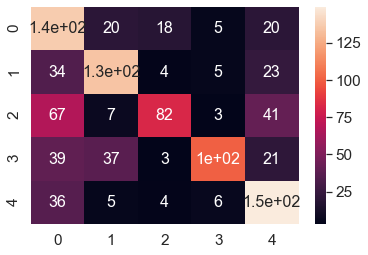

In [26]:
import seaborn as sn
import matplotlib.pyplot as plt

array = sklearn.metrics.confusion_matrix(test_Y, y_pred)
#print(cm)

df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

